# The entire thing can be run in the background by running the next cell, or it can be stepped through gradually by running each cell consecutively.

In [1]:
%run SyphilisModel

Burning in population
Equilibrium incidence = 11.425 per 100,000
Beginning experiment
Plotting effects of intervention
Plotting screening interval that leads to eradication


<Figure size 720x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### Parameters and variables

In [135]:
#Initial population values. Each class begins with one case of primary syphilis
E = 0 #exposed
YP = 1 #primary syph
YS = 0 #secondary syph
L = 0 # late latent syph
EL = 0 #early laten syph
YRS = 0 #recurrent secondary syph
Z = 0 #partial immunity (temporary)
Yt = 0 #tertiary syph

#initial compartment values for each class in a list
init1 = [N1-1, E, 1, YS, L, EL, YRS, Z, Yt] #values for class 1
init2 = [N2-1, E, 1, YS, L, EL, YRS, Z, Yt] #values for class 2
init3 = [N3-1, E, 1, YS, L, EL, YRS, Z, Yt] #values for class 3
init = init1 + init2 + init3 #make a single list containing all values

#Activity class values
Ntot = 100000 #total population size

#Size of population for classes 1, 2, and 3
nClasses = 3
N1 = 0.72*Ntot     
N2 = 0.15*Ntot         
N3 = 0.13*Ntot 

#Number of partnerships for classes 1, 2, and 3
C1 = 2 
C2 = 8
C3 = 30
totC = (N1*C1)+(N2*C2)+(N3*C3) #total partnerships

#make a list of lists of parameters for each sexual activity class
class1 = [(N1*C1/totC), N1, C1]
class2 = [(N2*C2/totC), N2, C2]
class3 = [(N3*C3/totC), N3, C3]
sexclass = [class1, class2, class3] 

             
#parameters
sig1 = 1/21 #Average incubation period, days, E -> YP
sig2 = 1/46 #Average time, days, spent YP -> YS
sig3 = 1/108 #Average time, days, spent YS -> L and YS -> EL and YRS -> L
sig4 = 0.5 # Rate per year EL -> YRS 
sig5 = 0.033 #Rate per year L -> Yt
gamma = 0.2 #Average rate of loss of immunity following treatment
nu = 0.25 #Proportion of individuals in 2° stage who progress to early latent stage	
beta = 0.003042 #calibrated value
m = 0.033 #Entry/exit rate
tau = 0 #Average treatment rate

In [138]:
def transmission(time, current_state, sexclass, beta, m, tau, sig1, sig2, sig3, sig4, sig5, gamma, nu):
    '''
    Compartmental model for all population values. Called by solve_ivp()
    Input:
    time: times at which to store the computer solutions
    current_state: flat list containing current population values for all classes
    sexclass: list of lists, with each list containing parameters for one behaviour class
    constant model parameters: beta:nu
    
    Output:
    nStep: flat list containing updated values of current_state 

    '''
    step = []
    slices = np.linspace(0, len(current_state), len(sexclass)+1) #get indices of current_state corresponding to each class. len(sexclass) is number of classes. +1 to give endpoint
    lambdas = get_lambda(current_state, sexclass, beta) #Get lambda value for all activity classes
    nStep = [] #Initialize vector to be returned with the next set of values
    for i in range(len(sexclass)): # Do the step for each sex activity class
        X, E, YP, YS, L, EL, YRS, Z, Yt = current_state[int(slices[i]):int(slices[i+1])] #Unpack the values of current_state for each class
        lam = lambdas[i]
        N = sexclass[i][1]
        fX = m*N + tau*YP + tau*YS + gamma*Z - (lam+m)*X
        fE =  lam*X-(sig1+m)*E
        fYP = sig1*E -(m+tau+sig2)*YP
        fYS = sig2*YP - (m+tau+sig3)*YS
        fEL =  nu*sig3*YS - (m + tau + sig4)*EL
        fYRS = sig4*EL - (m + tau + sig3)*YRS
        fL = sig3*YRS + (1 - nu)*sig3*YS - (sig5 + m + tau)*L
        fYt = sig5*L - (m + tau)*Yt
        fZ = tau*L + tau*Yt + tau*YRS + tau*EL - (gamma + m)*Z
        nStep += [fX, fE, fYP, fYS, fL, fEL, fYRS, fZ, fYt]
    return nStep


In [11]:
def get_lambda(current_state, sexclass, beta):    
    '''
    Calculate the lambda for each sexual activity class. Called by transmission()
    Input:
    current state: list of current state for each behaviour class
    sexclass: list of lists containing parameters for each class 
    beta: probability of transmission per partnership
    
    Output:
    list of force of infection for each class
    '''
    propInf = 0
    slices = np.linspace(0, len(current_state), len(sexclass)+1) #get indices of current_state corresponding to each class. len(sexclass) is number of classes. +1 to give endpoint
    cList = []
    for i in range(len(sexclass)): #for each class
        prop, N, C = sexclass[i] #unpack class parameters
        X, E, YP, YS, L, EL, YRS, Z, Yt = current_state[int(slices[i]):int(slices[i+1])] #unpack class state
        yInf = (YP+YS+YRS)/N #get class contribution to lambda
        classProp = prop*yInf
        cList.append(C) #Store the partner value in a list so the entire list doesn't have to be unpacked twice
        propInf += classProp  
    lamList = []
    for C in cList:
        lam = C*beta*propInf
        lamList.append(lam) 
    return lamList

In [232]:
def get_incidence_vals(result, pos, nClasses):
    '''
    Calculate sum of any population value over all acivity classes to get values to be used in plot. Called after solve_ivp()
    Input: 
    result: Flat list of all population values received from solve_ivp()
    pos: position in list of desired value, e.g. if desired output is YP, pos will be 3
    nClasses: number of sexual behaviour classes
    
    Output:
    inf: list of incidence over time summed over the classes
    final: summed incidence at the last timestep
    
    '''
    pos = pos-1 # -1 to use as index for the list
    inf = 0 #initialize list which will contained summed YP at each time step
    infFin = 0 #initialize sum
    slices = np.linspace(0, len(result.y), nClasses+1) #get indices of current_state corresponding to the first value of each class 
    for i in range(nClasses):
        YP = result.y[int(pos+slices[i]),:] #get desired value from each class using pos to offset the first index value of each class
        inf += YP #sum the lists
        infFin += YP[len(YP)-1] #sum values from the final time step
    return inf, infFin.item()


# Burn in population to equilibrium 

In [2]:
time = np.linspace(0, 300000, 10) #creates list of 10 time points between simulation start (0) and simulation end (300000) to record the state 

result = solve_ivp(transmission, (0,300000),init, t_eval = time,args = (sexclass, beta, m, tau, sig1, sig2, sig3, sig4, sig5, gamma, nu)) # model function, duration, initial state, evaluation times, parameters)
eqVals = result.y[:,9] #save equilibrium values: 10 states recorded, so 9 is the last one because there are 10 states recorded and we want the last one

Text(0.5, 1.0, 'Burn in: equilibrium incidence = 11.425')

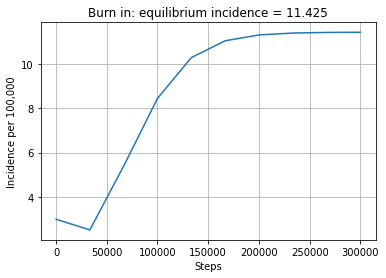

In [171]:
inf, final = get_incidence_vals(result, 3, nClasses)

plt.plot(time, inf) 
plt.grid(linewidth=0.2)
plt.xlabel('Steps')
plt.ylabel('Incidence per 100,000')
plt.title('Burn in: equilibrium incidence = %1.3f' %final)

# Begin screening

Text(0.5, 1.0, 'Syphillis incidence with and without intervention')

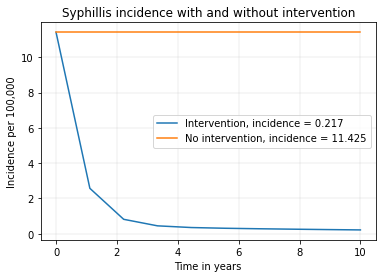

In [4]:
tau = 1.4117 #screening threshhold 0.099

time = np.linspace(0, 10, 10)
result = solve_ivp(transmission, (0,10), eqVals, t_eval = time,args = (sexclass, beta, m, tau, sig1, sig2, sig3, sig4, sig5, gamma, nu))
inf, final = get_incidence_vals(result, 3, nClasses)

tau = 0
time = np.linspace(0, 10, 10)
result = solve_ivp(transmission, (0,10), eqVals, t_eval = time,args = (sexclass, beta, m, tau, sig1, sig2, sig3, sig4, sig5, gamma, nu))
infUn, finalUn = get_incidence_vals(result, 3, nClasses)

plt.plot(time, inf, label='Intervention, incidence = %1.3f' %final)
plt.plot(time, infUn, label='No intervention, incidence = %1.3f' %finalUn)
plt.grid(linewidth=0.2)
plt.legend()
plt.ylabel('Incidence per 100,000')
plt.xlabel('Time in years')
plt.title('Syphillis incidence with and without intervention')

In [5]:
#get relative rate
relInc = 100/finalUn
relInf = [i*relInc for i in inf] #transform incidence rate 

Text(0.5, 1.0, 'Relative incidence of syphilis following intervention')

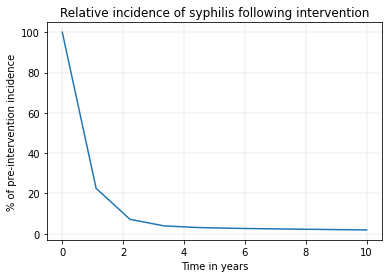

In [6]:
#get relative rate
relInc = 100/finalUn
relInf = [i*relInc for i in inf] #transform incidence rate 

plt.plot(time, relInf)
plt.grid(linewidth=0.2)
plt.ylabel('% of pre-intervention incidence')
plt.xlabel('Time in years')
plt.title('Relative incidence of syphilis following intervention')

# Calculate the screening interval that leads to eradication

In [241]:
tVals = np.linspace(1, 12, 100) #get 100 values for tau between 1 and 12 
time = np.linspace(0, 20, 2) 

endV = []
for t in tVals:
    tau = t
    result = solve_ivp(SIR, (0,20), eqVals, t_eval = time,args = (sexclass, beta, m, tau, sig1, sig2, sig3, sig4, sig5, gamma, nu))
    inf, final = get_incidence_vals(result, 3, nClasses)
    endV.append(final)

tInt = [12/i for i in tVals] #convert tau to screening intervals
   

Text(0.5, 1.0, 'Effect of screening interval on syphillis eradication')

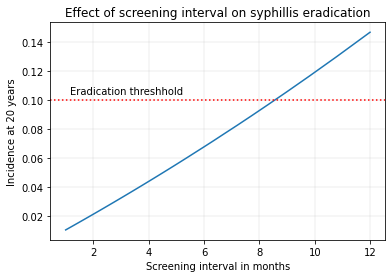

In [242]:
plt.plot(tInt, endV)
plt.grid(linewidth=0.2)
plt.ylabel('Incidence at 20 years')
plt.xlabel('Screening interval in months')
plt.axhline(y = 0.1, color = 'r', linestyle = ':')
plt.annotate('Eradication threshhold', xy=(1.15, 0.104), xytext=(1.15, 0.104))
plt.title('Effect of screening interval on syphillis eradication')

### tau = 1.4117 produces the threshhold value of 0.099